In [ ]:
# split the data into train, val and test folders
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Read the CSV file and shuffle the rows
df = pd.read_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df.csv').sample(frac=1).reset_index(drop=True)
# Create a new column of filename
df['filename'] = df['image_path'].apply(lambda x: os.path.basename(x))
# save the df
df.to_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new.csv', index=False)

source_folder_path = '/mnt/g/Datasets/Body_Parts_XRay/images/train/'
dest_folder_path = '/mnt/g/Datasets/Body_Parts_XRay/Original/'

# Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Define a function to copy files
def copy_files(df, dest_folder):
    for index, row in df.iterrows():
        filename = row['filename']
        src_file = os.path.join(source_folder_path, filename)
        dest_file = os.path.join(dest_folder_path, dest_folder, 'images',filename)
        shutil.copy(src_file, dest_file)

# Copy files to their respective folders
copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

In [5]:
from PIL import Image
import numpy as np
source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/train/images/1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162-c.png'
img = Image.open(source_folder)
img = np.array(img)
print(img)

[[200 201 202 ...  27  27  27]
 [199 200 201 ...  26  27  27]
 [203 202 202 ...  26  27  27]
 ...
 [ 27  27  27 ...  17   0   1]
 [ 26  27  27 ...  35   0   0]
 [ 27  27  26 ...  50   8   0]]


In [6]:
# Remove 4 black regions at all 4 edges. Add black padding to make it square
from PIL import Image
import os

def remove_dark_edges(source_folder, destination_folder):
    """Remove dark edges from the image."""

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    def remove_dark_edges(img):
        """Remove dark edges from the image."""
        data = img.load()
        width, height = img.size
        
        left, right = 0, width
        top, bottom = 0, height
        
        def is_dark(pixel):
            if isinstance(pixel, int):
                return pixel < 5
            return pixel < (5, 5, 5)
        
        # Check left edge
        for x in range(width):
            if not is_dark(data[x, height // 2]):
                left = x
                break
                
        # Check right edge
        for x in range(width - 1, -1, -1):
            if not is_dark(data[x, height // 2]):
                right = x + 1
                break
                
        # Check top edge
        for y in range(height):
            if not is_dark(data[width // 2, y]):
                top = y
                break
                
        # Check bottom edge
        for y in range(height - 1, -1, -1):
            if not is_dark(data[width // 2, y]):
                bottom = y + 1
                break
                
        return img.crop((left, top, right, bottom))

    def add_black_padding(img):
        """Add black padding to make the image square."""
        width, height = img.size
        size = max(width, height)
        
        new_img = Image.new("RGB", (size, size), color=(0, 0, 0))
        new_img.paste(img, ((size - width) // 2, (size - height) // 2))
        
        return new_img

    for image_file in os.listdir(source_folder):
        if image_file.endswith('.png'):
            img_path = os.path.join(source_folder, image_file)
            img = Image.open(img_path)
            
            img = remove_dark_edges(img)
            if img.width != img.height:
                img = add_black_padding(img)
                
            img.save(os.path.join(destination_folder, image_file))


source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/train/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images'
remove_dark_edges(source_folder, destination_folder)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/val/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/images'
remove_dark_edges(source_folder, destination_folder)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/images'
remove_dark_edges(source_folder, destination_folder)

In [ ]:
source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images/'
image_files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
print(image_files[:5])

In [74]:
#Calculate the mean and standard deviation of the dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose
from torch.utils.data import DataLoader

dataset_path = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/'

# Define the transform
transform = Compose([
    Resize((512, 512)),  # Resize all images to 512x512
    ToTensor()
])

# Create the dataset with the transform
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create the DataLoader with the transformed dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# Compute the mean and standard deviation
mean = 0.
std = 0.
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader.dataset)
std /= len(dataloader.dataset)

print(mean, std) #tensor([0.4233, 0.4233, 0.4233]) tensor([0.2114, 0.2114, 0.2114])


tensor([0.3453, 0.3453, 0.3453]) tensor([0.2566, 0.2566, 0.2566])


In [ ]:
# https://github.com/mlfoundations/open_clip/issues/439

#Code to implement data augmentation: --aug-cfg scale='(0.33, 1.0)' re_prob=0.35
"""
A.Affine(rotate=(-15, 15), translate_percent=(0.0, 0.25), shear=(-3, 3), p=0.5),
A.RandomResizedCrop(image_size[0], image_size[1], scale=(0.9, 1.0), ratio=(0.75, 1.3333333333)),
A.ToGray(p=0.1),
A.GaussianBlur(blur_limit=(3, 7), p=0.05),
A.GaussNoise(p=0.05),
A.RandomGridShuffle(grid=(2, 2), p=0.3),
A.Posterize(p=0.2),
A.RandomBrightnessContrast(p=0.5),
A.Cutout(p=0.05),
A.RandomSnow(p=0.1),
A.RandomRain(p=0.05),
A.HorizontalFlip(p=0.5),
"""

from torchvision.transforms import Normalize, Compose, RandomResizedCrop, InterpolationMode, ToTensor, Resize, CenterCrop

def _convert_to_rgb(image):
    return image.convert('RGB')
normalize = Normalize(mean=mean, std=std)
train_transform = Compose([
    RandomResizedCrop(
        image_size,
        scale=aug_cfg_dict.pop('scale'),
        interpolation=InterpolationMode.BICUBIC,
    ),
    _convert_to_rgb,
    ToTensor(),
    normalize,
])

In [ ]:
from torchvision.transforms import (Normalize, Compose, RandomResizedCrop, RandomRotation, 
                                   RandomHorizontalFlip, ColorJitter, RandomAffine, 
                                   GaussianBlur, RandomCrop, RandomErasing, InterpolationMode, 
                                   ToTensor, Resize, CenterCrop)

def _convert_to_rgb(image):
    return image.convert('RGB')

normalize = Normalize(mean=mean, std=std)

train_transform = Compose([
    RandomRotation(degrees=15),  # Small rotations
    RandomResizedCrop(           # Scaling and Zooming
        image_size,
        scale=aug_cfg_dict.pop('scale'),
        interpolation=InterpolationMode.BICUBIC,
    ),
    RandomHorizontalFlip(p=0.5),  # Horizontal Flip
    ColorJitter(brightness=0.2, contrast=0.2),  # Brightness and Contrast Adjustments
    # Note: torchvision doesn't have a direct function for translation. 
    # But, RandomAffine with 'translate' can achieve this.
    RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation (10% of total image size)
    # Note: torchvision doesn't have elastic deformation or histogram equalization.
    RandomCrop(size=image_size, padding=10),  # Cropping
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Gaussian Blur
    RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),  # Cutout or Random Erasing
    _convert_to_rgb,
    ToTensor(),
    normalize,
])
"""
This transform chain integrates the suggested augmentations. Some points to consider:

Ensure that the order of transformations is appropriate. For example, always apply ToTensor() before Normalize().
For augmentations not available in torchvision, you might want to integrate the albumentations library, which offers a rich set of image transformations.
Always consult with domain experts (in this case, radiologists or medical imaging experts) to ensure that the chosen augmentations do not introduce artifacts that could mislead the model.
"""

In [113]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torchvision.transforms import (Normalize, Compose, RandomResizedCrop, RandomRotation, 
                                   RandomHorizontalFlip, ColorJitter, RandomAffine, 
                                   GaussianBlur, RandomCrop, RandomErasing, InterpolationMode, 
                                   ToTensor, Resize, CenterCrop)
OPENAI_DATASET_MEAN = (0.3453, 0.3453, 0.3453)#(0.48145466, 0.4578275, 0.40821073)
OPENAI_DATASET_STD = (0.2566, 0.2566, 0.2566)#(0.26862954, 0.26130258, 0.27577711)
# [0.3453, 0.3453, 0.3453]) tensor([0.2566, 0.2566, 0.2566]
# ([0.4233, 0.4233, 0.4233]) tensor([0.2114, 0.2114, 0.2114])
class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, img):
        img = F.to_tensor(img).numpy() * 255  # Convert to numpy array in range [0, 255]
        img = img.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        img = self.transform(image=img)['image']
        img = F.to_pil_image(img.astype('uint8'))  # Convert back to PIL image
        return img

def _convert_to_rgb(image):
    return image.convert('RGB')
normalize = Normalize(mean=OPENAI_DATASET_MEAN, std=OPENAI_DATASET_STD)
# Albumentations transformations
albu_transforms = A.Compose([
    # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  # Elastic deformation
    # A.HistogramMatching(p=0.5, reference_images=None),  # Histogram Equalization (note: you need reference images)
    # Add any other albumentations transforms here
    A.GaussianBlur(p=0.2, blur_limit=(3, 7))
])

# torchvision transforms
pre_transforms = Compose([
    
    RandomRotation(degrees=15),
    RandomResizedCrop(
        (224,224),
        scale=(0.9, 1.1),
        interpolation=InterpolationMode.BICUBIC,
    ),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.15, contrast=0.15),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    RandomCrop(size=(224,224), padding=10),
    # GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
])

post_transforms = Compose([
    _convert_to_rgb,
    ToTensor(),
    normalize,
    RandomErasing(p=0.1, scale=(0.01, 0.05), ratio=(0.3, 3.3), value=0, inplace=False),  # Cutout or Random Erasing
])

train_transform = Compose([
    pre_transforms,
    AlbumentationsTransform(albu_transforms),
    post_transforms
])
"""
The AlbumentationsTransform class acts as a bridge between torchvision and albumentations.
The HistogramMatching transformation in albumentations requires a set of reference images to match the histogram. You'd need to specify that.
Always ensure that ToTensor() is one of the last transformations, because it changes the data type and order of dimensions.
Test the transformation pipeline on a few images to ensure it's working as expected.
"""

# https://www.kaggle.com/code/raddar/popular-x-ray-image-normalization-techniques
# https://towardsdatascience.com/deep-learning-in-healthcare-x-ray-imaging-part-5-data-augmentation-and-image-normalization-1ead1c02cfe3

"\nThe AlbumentationsTransform class acts as a bridge between torchvision and albumentations.\nThe HistogramMatching transformation in albumentations requires a set of reference images to match the histogram. You'd need to specify that.\nAlways ensure that ToTensor() is one of the last transformations, because it changes the data type and order of dimensions.\nTest the transformation pipeline on a few images to ensure it's working as expected.\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


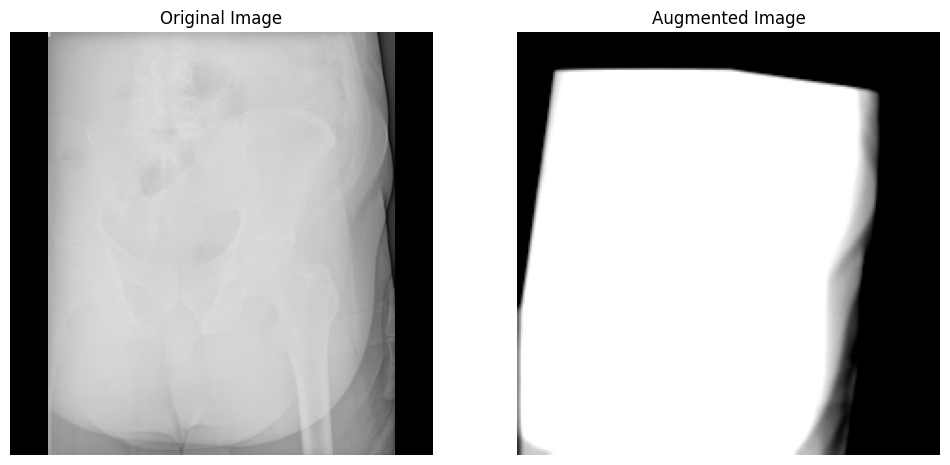

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


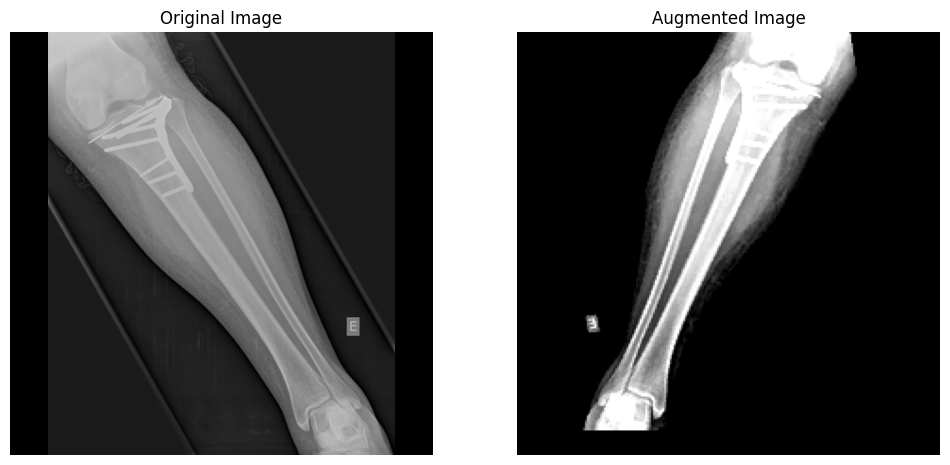

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


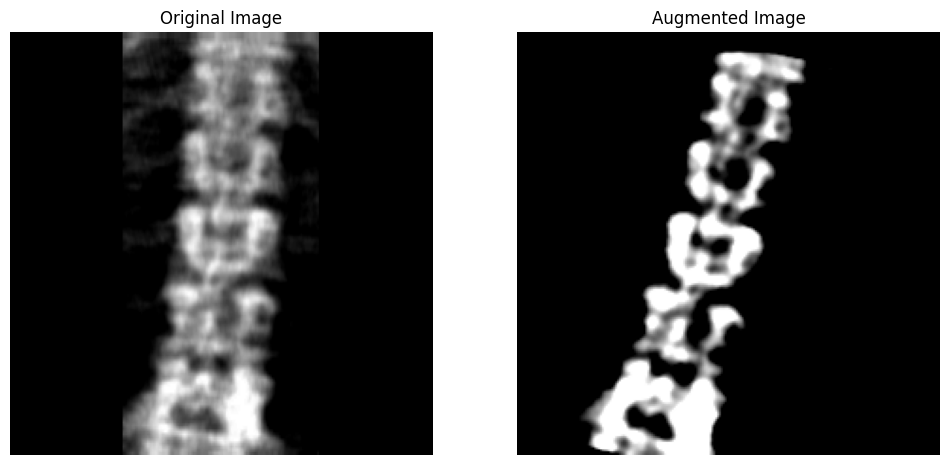

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


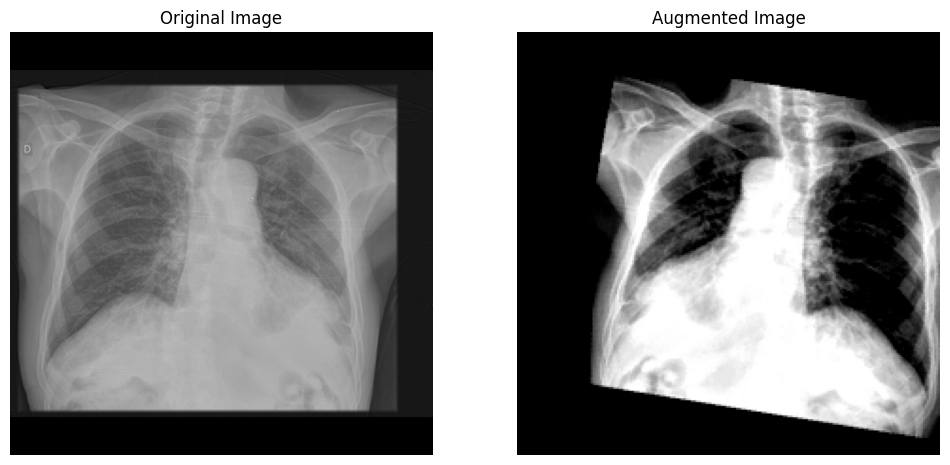

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


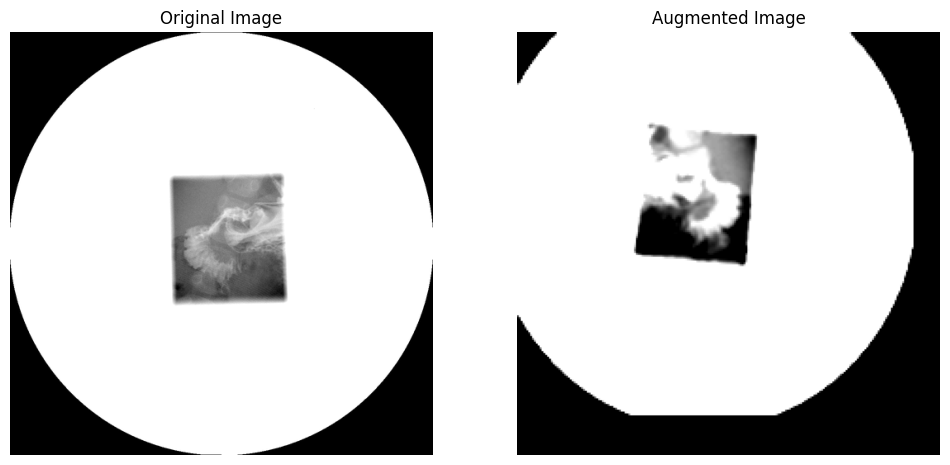

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


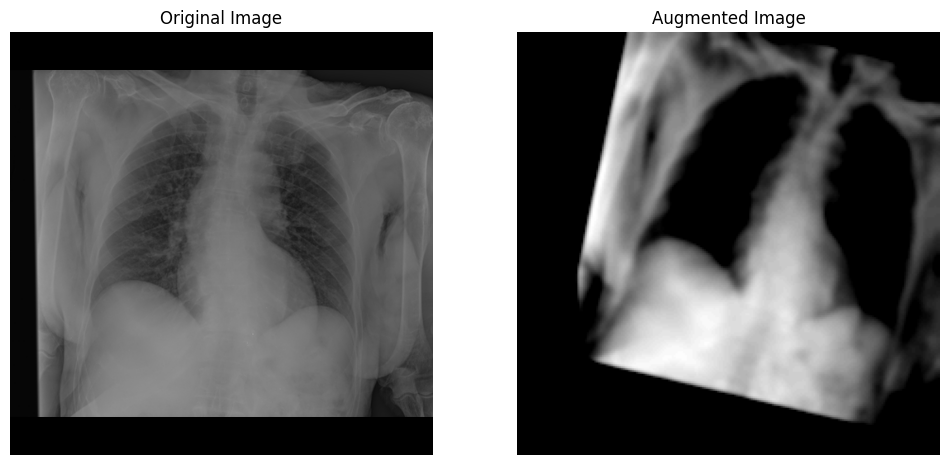

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


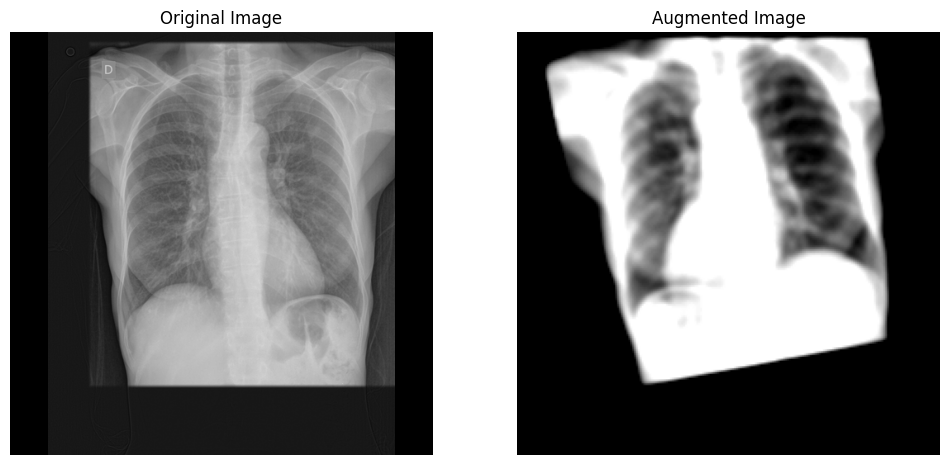

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


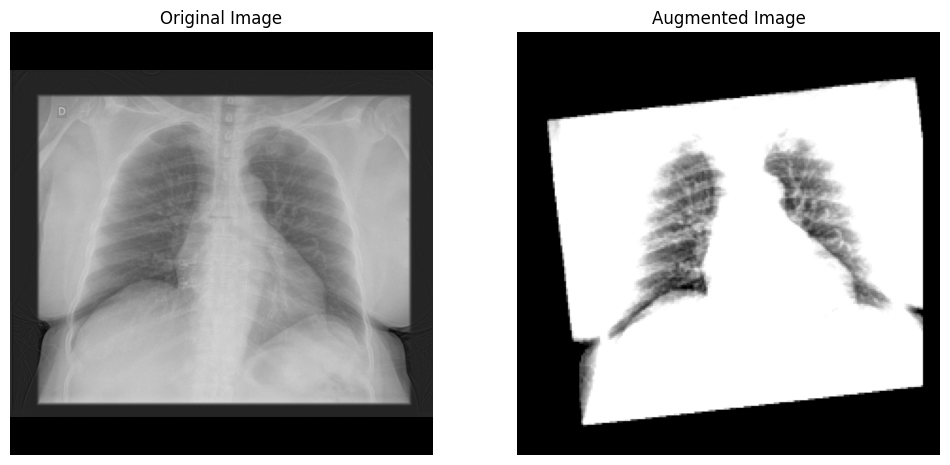

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


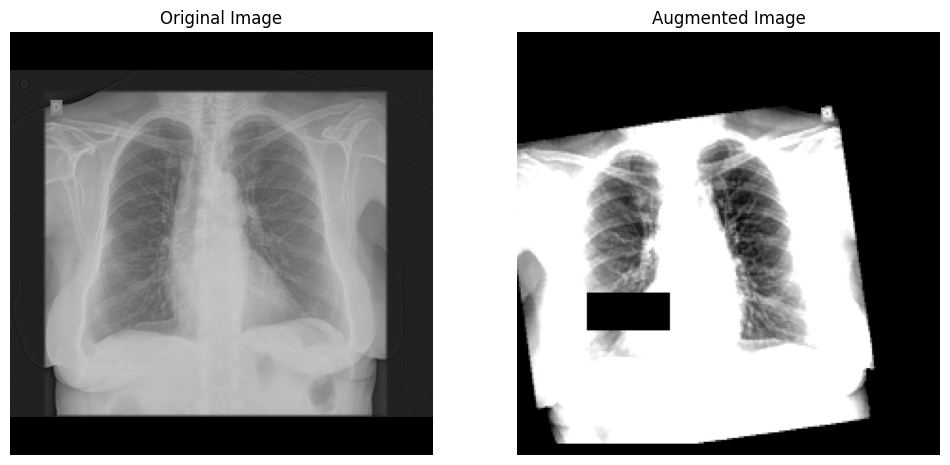

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


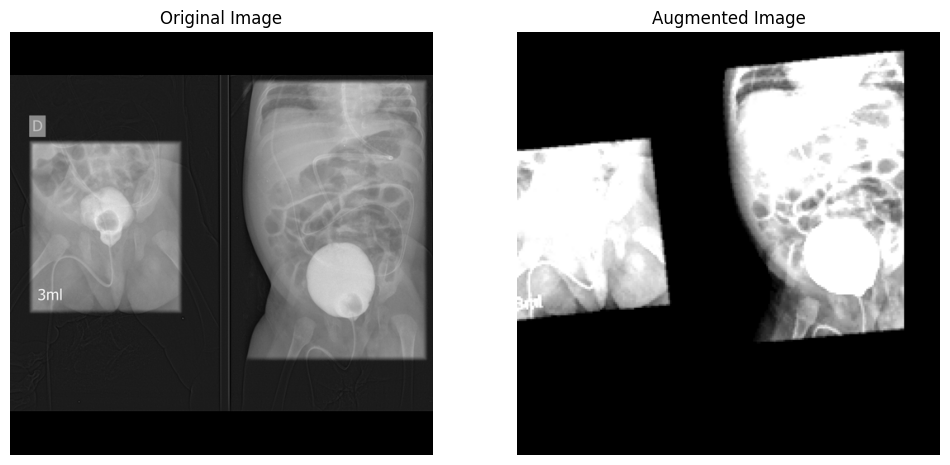

In [114]:
"""
To visualize the augmentation on a few images, you can follow the steps below:

Load a few images.
Apply the transformation pipeline train_transform to each image.
Display the original and augmented images side by side using matplotlib.

Remember to change path_to_your_images to the directory where your images are located. 
The code will display the original and augmented images side by side for the first five images in the directory. 
This will allow you to inspect the effects of your augmentation pipeline.
"""
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def visualize_augmentations(original_img, augmented_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img, cmap="gray") #
    ax[0].set_title("Original Image")
    ax[1].imshow(augmented_img, cmap="gray")
    ax[1].set_title("Augmented Image")
    for a in ax:
        a.axis("off")
    plt.show()

# Load a few images
image_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images'  # Change this to your image directory
sample_images = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)[:10]]

for image_path in sample_images:
    original_img = Image.open(image_path)
    augmented_img = train_transform(original_img)
    augmented_img = augmented_img.permute(1, 2, 0)  # Convert CxHxW to HxWxC for visualization
    visualize_augmentations(original_img, augmented_img)


In [10]:
# generate captions.txt for image folder
import pandas as pd
import os
# Dictionary to map integers to tissue types
tissue_map = {
    0: "Abdomen",
    1: "Ankle",
    2: "Cervical Spine",
    3: "Chest",
    4: "Clavicles",
    5: "Elbow",
    6: "Feet",
    7: "Finger",
    8: "Forearm",
    9: "Hand",
    10: "Hip",
    11: "Knee",
    12: "Lower Leg",
    13: "Lumbar Spine",
    14: "Others",
    15: "Pelvis",
    16: "Shoulder",
    17: "Sinus",
    18: "Skull",
    19: "Thigh",
    20: "Thoracic Spine",
    21: "Wrist"
}

def generate_caption (source_folder, output_file):
    # List all jpg images in the source folder
    image_files = [f for f in os.listdir(source_folder) if f.endswith('.png')]

    # Extract the base name of the image files
    df = pd.read_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new1.csv')

    # Create a new column 'tissue_types' to store the tissue types in a readable format
    # def map_to_tissue(target):
    #     tissue_types = [tissue_map[int(t)] for t in target.split()]
    #     return ", ".join(tissue_types)
    # df['tissue_types'] = df['Target'].apply(map_to_tissue)
    # Optionally, save the updated dataframe to a new CSV
    # df.to_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new1.csv', index=False)

    # Open the output txt file for writing
    with open(output_file, 'w') as f:
        for filename in image_files:
            base_name = os.path.splitext(filename)[0]
            #Look up the tissue types based on the filename
            image_tissue_types = df[df['filename'] == filename]['tissue_types'].values[0]
            # Write to the txt file
            f.write(f"{base_name}\t{image_tissue_types}\n")


source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/captions.txt'
generate_caption (source_folder, output_file)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/captions.txt'
generate_caption (source_folder, output_file)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/captions.txt'
generate_caption (source_folder, output_file)

In [ ]:
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/train" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "train_square.csv"
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/val/" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "val_square.csv"
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/test" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "test_square.csv"
# /home/yilu/Development/open_clip/Body_Parts_XRay/image_augmentation.py